# Audio Computing Lab 1
## Forward and Inverse STFT transforms
Gizem Tabak

## Part 1. The forward transform

We will design a function that uses five different arguments as follows:

    stft_output = stft( input_sound, dft_size, hop_size, zero_pad, window)

    input_sound is a 1d array that contains an input sound.

    dft_size is the DFT point size that you will use for this analysis.

    hop_size is the number of samples that your analysis frame will advance. 

    zero_pad is the amount of zero-padding that you will use.

    window is a vector containing the analysis window that you will be using.

In [ ]:
%matplotlib inline

import numpy as np
import scipy.io.wavfile as wv
import matplotlib.pyplot as plt

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    if len(np.shape(input_sound)) == 1:
        # Forward transform
        input_sound_padded = np.zeros(len(input_sound) + dft_size + hop_size - len(input_sound)%hop_size)
        input_sound_padded[:len(input_sound)] = input_sound
        L = len(input_sound_padded) -  dft_size
        stft_output = np.zeros([int((dft_size + zero_pad)/2) + 1, int(L/hop_size)], dtype=complex)
        for i in range(0, int(L/hop_size)):
            seg = input_sound_padded[(i*hop_size):(i*hop_size + dft_size)]
            # Choose and apply window if selected
            if window == 'triangular':
                seg = np.multiply(seg, np.bartlett(dft_size))
            elif window == 'hanning':
                seg = np.multiply(seg, np.hanning(dft_size))
            elif window == 'hamming':
                seg = np.multiply(seg, np.hamming(dft_size))
            elif window == 'kaiser':
                seg = np.multiply(seg, np.kaiser(dft_size, beta=0.8))
            # Change size variable so that it will pad zeros to input    
            s_stft = np.fft.rfft(seg, dft_size + zero_pad)            
            stft_output[:,i] = s_stft
        X = np.arange(0, (int(L/hop_size)*hop_size)/fs, hop_size/fs)
        Y = np.arange(0, fs/2, fs/(2*(int((dft_size + zero_pad)/2) + 1)))
        # Make zero elements equal to the smallest value to avoid log(0) for plotting
        min_nonzero = np.min(stft_output[np.nonzero(stft_output)])
        stft_output[stft_output == 0] = min_nonzero
        
        plt.pcolormesh(X, Y, 20*np.log10(np.abs(stft_output)))
        plt.xlabel('Time (sec)')
        plt.ylabel('Freq (Hz)')
        plt.title('DFT=%d HOP=%d PAD=%d WINDOW=%s' %(dft_size, hop_size, zero_pad, window))

        plt.show()
        return stft_output
    elif len(np.shape(input_sound)) == 2:
        # Inverse transform
        L = (np.shape(input_sound)[1]+1)*hop_size
        stft_output = np.zeros([int(L)+hop_size,])
        for i in range(0, int((L - dft_size - zero_pad)/hop_size)):
            s_stft = np.fft.irfft(input_sound[:,i], dft_size+zero_pad)
            if len(window) > 0:
                # Window should only cover nonzero part, not zero paddings
                if window == 'triangular':
                    w = np.bartlett(dft_size)
                elif window == 'hanning':
                    w = np.hanning(dft_size)
                elif window == 'hamming':
                    w = np.hamming(dft_size)
                elif window == 'kaiser':
                    w = np.kaiser(dft_size, beta=0.8)
                # Pad window with zeros to make dimensions equal
                window_padded = np.concatenate([w, np.zeros([zero_pad,])])
                s_stft = np.multiply(s_stft, window_padded)
            # Overlap and add
            stft_output[i*hop_size:(i*hop_size + dft_size + zero_pad)] += s_stft
        
        return stft_output

def plot_reconstructed(reconst_input_sound, input_sound, dft_size, hop_size, zero_pad, window):
    t_in = np.arange(0, len(input_sound)/fs, 1/fs)
    t_out = np.arange(0, len(reconst_input_sound)/fs, 1/fs)
    plt.plot(t_in, input_sound, alpha = 0.5)
    plt.plot(t_out, reconst_input_sound, alpha = 0.5)
    plt.xlabel('Time (sec)')
    plt.legend(['Original', 'Reconstructed'])
    plt.title('DFT=%d HOP=%d PAD=%d WINDOW=%s' %(dft_size, hop_size, zero_pad, window))
    plt.show()

#### DFT Size
In the first plot, DFT size is relatively low compared to the second plot. In both plots, hop size 64 and all other parameters are zero. As it is seen, low DFT size results in blurry frequencies and increasing DFT size enhances frequency resolution. As I increase the DFT size, I observe more harmonics and the distinction between harmonics are more clear. However, if I increase it too much, frequecies start to "dissolve".



PIANO.WAV


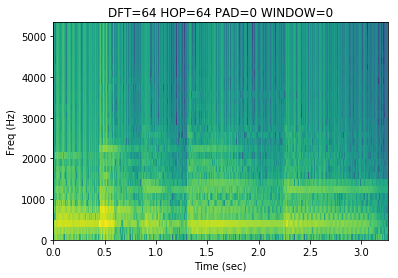

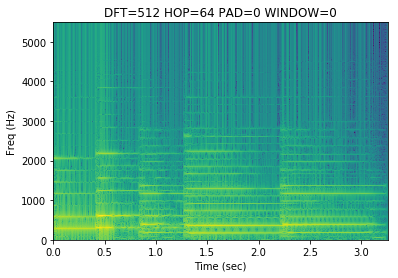

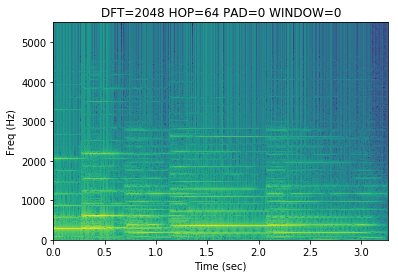

In [ ]:
fs, input_sound = wv.read('piano.wav')
print('PIANO.WAV')
stft_output = stft(input_sound, dft_size=64, hop_size=64, zero_pad=0, window=0)
stft_output = stft(input_sound, dft_size=512, hop_size=64, zero_pad=0, window=0)
stft_output = stft(input_sound, dft_size=2048, hop_size=64, zero_pad=0, window=0)

#### Hop Size
As I decrease the hop size, frequency lines continuing over time becomes more straight, i.e. less noisy and smoother. When the hop size is equal to DFT size, I observe discontinuities along the time axis and when the hop size is greater than DFT size, there are obvious gaps, which is expected since we ommit some smaples while hopping.

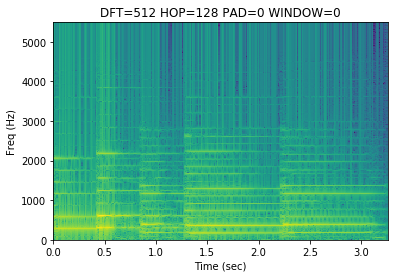

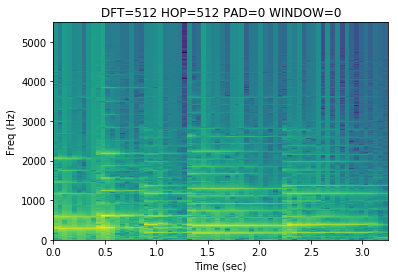

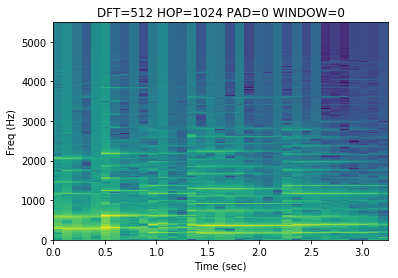

In [ ]:
stft_output = stft(input_sound, dft_size=512, hop_size=128, zero_pad=0, window=0)
stft_output = stft(input_sound, dft_size=512, hop_size=512, zero_pad=0, window=0)
stft_output = stft(input_sound, dft_size=512, hop_size=1024, zero_pad=0, window=0)

#### Zero padding
Adding zero padding makes frequency lines more clear when the DFT size is low. However, the lines are not as sharp compared to increasing DFT size, which makes sense since we actually do not add any information to a segment by padding it with zero.

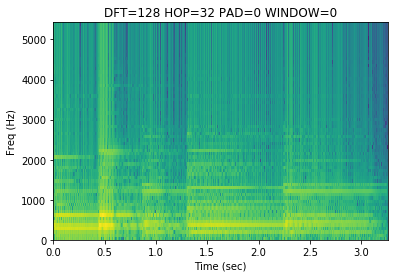

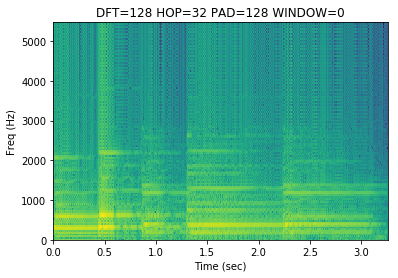

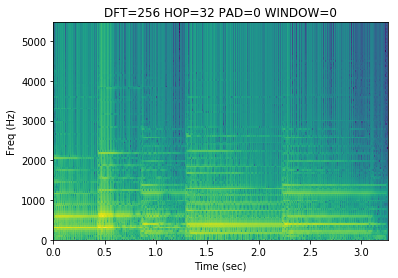

In [ ]:
stft_output = stft(input_sound, dft_size=128, hop_size=32, zero_pad=0, window=0)
stft_output = stft(input_sound, dft_size=128, hop_size=32, zero_pad=128, window=0)
stft_output = stft(input_sound, dft_size=256, hop_size=32, zero_pad=0, window=0)

#### Windowing
Windowing eliminates artifacts coming from combining hopped regions. As a result, all the frequency lines are smooth and connected, and notes and their timings are much more visible. Hamming and Kaiser windows do not perform as good as Triangular and Hanning since their end points are not zero and hence they do not taper out the segments completely.

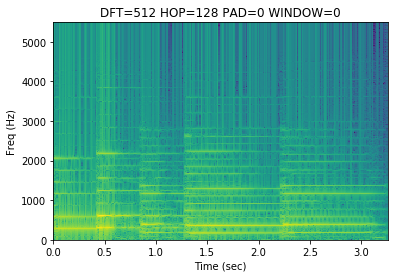

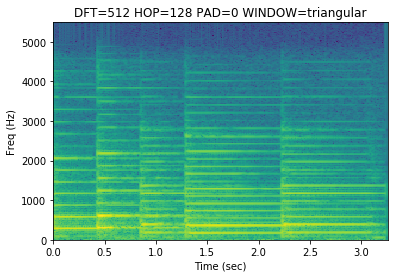

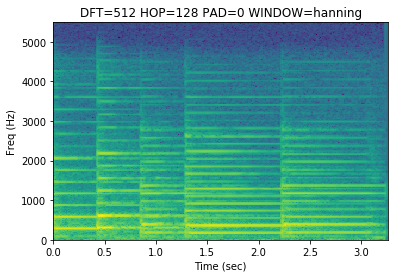

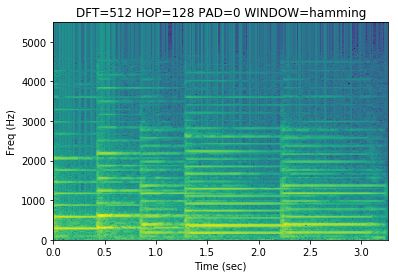

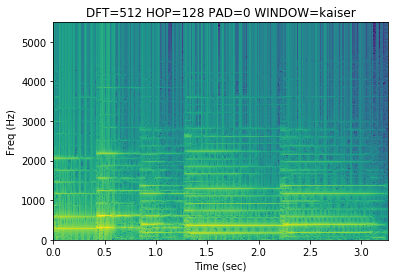

In [ ]:
stft_output = stft(input_sound, dft_size=512, hop_size=128, zero_pad=0, window=0)
stft_output = stft(input_sound, dft_size=512, hop_size=128, zero_pad=0, window='triangular')
stft_output = stft(input_sound, dft_size=512, hop_size=128, zero_pad=0, window='hanning')
stft_output = stft(input_sound, dft_size=512, hop_size=128, zero_pad=0, window='hamming')
stft_output = stft(input_sound, dft_size=512, hop_size=128, zero_pad=0, window='kaiser')

#### Other files


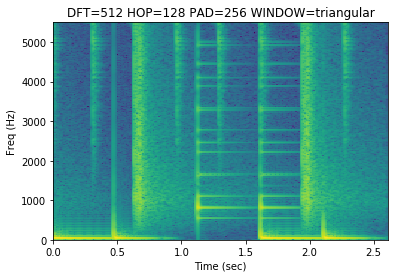

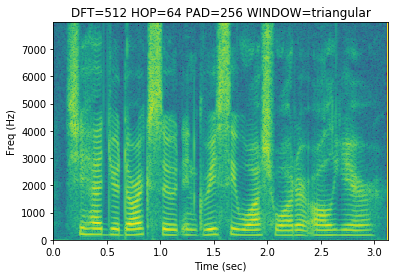

In [ ]:
fs, input_sound = wv.read('80s.wav')
stft_output = stft(input_sound, dft_size=512, hop_size=128, zero_pad=256, window='triangular')
fs, input_sound = wv.read('speech.wav')
stft_output = stft(input_sound, dft_size=512, hop_size=64, zero_pad=256, window='triangular')

## Part 2: The Inverse Transform

When the hop size and DFT size is the same, reconstruction is almost perfect without windowing.

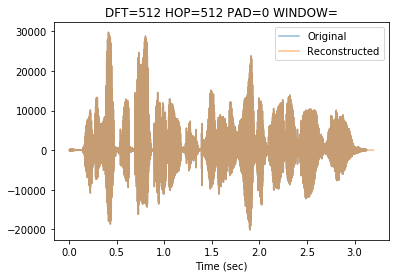

In [ ]:
fs, input_sound = wv.read('speech.wav')
dft_size=512
hop_size=512
zero_pad=0
window=''
# stft_output = stft(input_sound, dft_size, hop_size, zero_pad, window)
reconst_input_sound = stft(stft_output, dft_size, hop_size, zero_pad, window)
plot_reconstructed(reconst_input_sound, input_sound, dft_size, hop_size, zero_pad, window)

However, when I use windowing with no overlap between DFT segments, I see the tapering effects between segments in the reconstructed signal.

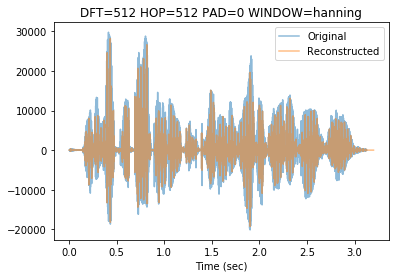

In [ ]:
dft_size=512
hop_size=512
zero_pad=0
window='hanning'
# stft_output = stft(input_sound, dft_size, hop_size, zero_pad, window)
reconst_input_sound = stft(stft_output, dft_size, hop_size, zero_pad, window)
plot_reconstructed(reconst_input_sound, input_sound, dft_size, hop_size, zero_pad, window)

In order to eliminate these artifacts, I decreased hop_size, which means increasing overlaps between segments. First, I tried 75% overlap with Hanning window. As mentioned, I observed amplitude artifacts. Reconstructed signal had higher amplitude because when the windows overlap at 75%, it does not sum up to 1, but sums up to a higher value.

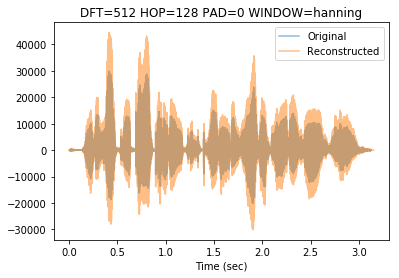

In [ ]:
dft_size=512
hop_size=int(dft_size/4)
zero_pad=0
window='hanning'
# stft_output = stft(input_sound, dft_size, hop_size, zero_pad, window)
reconst_input_sound = stft(stft_output, dft_size, hop_size, zero_pad, window)
plot_reconstructed(reconst_input_sound, input_sound, dft_size, hop_size, zero_pad, window)

When I use 50% overlap, the reconstructed signal is much closer to the original one, which makes sense when we look at the second plot: The consecutive windows sum to 1 at each location on x-axis, meaning it does not increase or decrease amplitude when multiplied with the signal and added constructively.

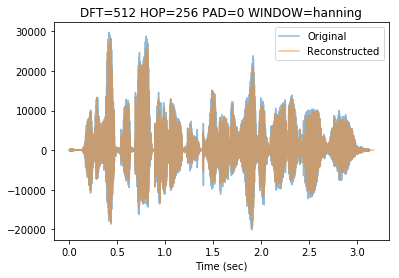

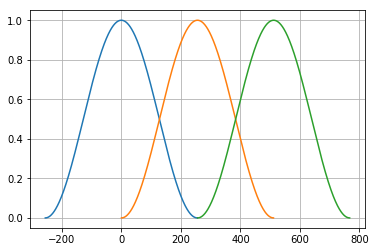

In [ ]:
fs, input_sound = wv.read('speech.wav')
dft_size=512
hop_size=int(dft_size/2)
zero_pad=0
window='hanning'
# stft_output = stft(input_sound, dft_size, hop_size, zero_pad, window)
reconst_input_sound = stft(stft_output, dft_size, hop_size, zero_pad, window)
plot_reconstructed(reconst_input_sound, input_sound, dft_size, hop_size, zero_pad, window)

plt.plot(np.arange(-hop_size, dft_size-hop_size), np.hanning(dft_size))
plt.plot(np.arange(0, dft_size), np.hanning(dft_size))
plt.plot(np.arange(hop_size, dft_size+hop_size), np.hanning(dft_size))
plt.grid(1)
plt.show()

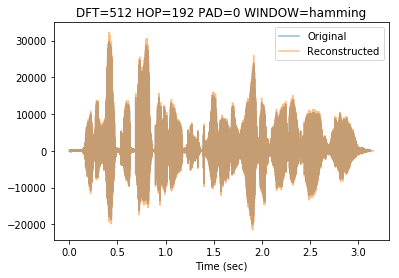

In [ ]:
dft_size=512
hop_size=int(3*dft_size/8)
zero_pad=0
window='hamming'
# stft_output = stft(input_sound, dft_size, hop_size, zero_pad, window)
reconst_input_sound = stft(stft_output, dft_size, hop_size, zero_pad, window)
plot_reconstructed(reconst_input_sound, input_sound, dft_size, hop_size, zero_pad, window)

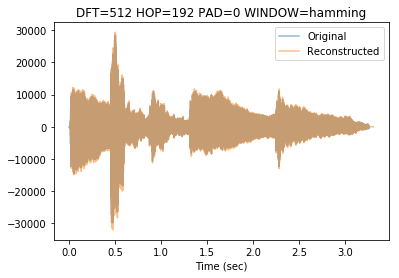

In [ ]:
fs, input_sound = wv.read('piano.wav')
dft_size=512
hop_size=int(3*dft_size/8)
zero_pad=0
window='hamming'
# stft_output = stft(input_sound, dft_size, hop_size, zero_pad, window)
reconst_input_sound = stft(stft_output, dft_size, hop_size, zero_pad, window)
plot_reconstructed(reconst_input_sound, input_sound, dft_size, hop_size, zero_pad, window)

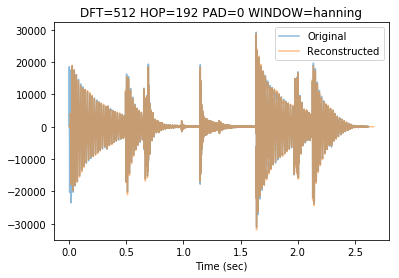

In [ ]:
fs, input_sound = wv.read('80s.wav')
dft_size=512
hop_size=int(3*dft_size/8)
zero_pad=0
window='hanning'
# stft_output = stft(input_sound, dft_size, hop_size, zero_pad, window)
reconst_input_sound = stft(stft_output, dft_size, hop_size, zero_pad, window)
plot_reconstructed(reconst_input_sound, input_sound, dft_size, hop_size, zero_pad, window)